In [1]:
import pickle
import faiss 
import torch
import numpy as np
import math
from asif import extract_candidate_sets_from_clusters
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
import sklearn
from operator import itemgetter 

In [2]:
data_folder = "data"

print("Loading dataset...")
lyrics = pickle.load(open(f"{data_folder}/lyrics.pkl", "rb"))
chords = pickle.load(open(f"{data_folder}/chords.pkl", "rb"))
artist_song = pickle.load(open(f"{data_folder}/artist_song.pkl", "rb"))

print("Loading precomputed embeddings...")
chords_embeddings = pickle.load(open(f"{data_folder}/chords_embeddings_sbert_chocolm.pkl", "rb"))
lyrics_embeddings = pickle.load(open(f"{data_folder}/lyrics_embeddings_sbert_roberta.pkl", "rb"))

Loading dataset...
Loading precomputed embeddings...


In [3]:
n_of_samples = 10_000
sample = random.sample(range(0, len(chords_embeddings)-1), n_of_samples)

chords_embeddings_sampled = chords_embeddings[sample]
lyrics_embeddings_sampled = lyrics_embeddings[sample]

lyrics_sampled = itemgetter(*sample)(lyrics)
chords_sampled = itemgetter(*sample)(chords)

computing_device = "cuda:0"

chords_embeddings_sampled = chords_embeddings_sampled.to(torch.float64).to(computing_device)
lyrics_embeddings_sampled = lyrics_embeddings_sampled.to(torch.float64).to(computing_device)

In [4]:
def compute_relative_coordinates(candidate_embeddings, embeddings, denoise=True, k=800, p=8):
        
        sim = (1 / (1 + torch.cdist(candidate_embeddings, embeddings)))

        if not denoise:
              return torch.nn.functional.normalize(sim)
        
        result = torch.zeros(sim.size())
        
        for i, j in enumerate(torch.argsort(sim, descending=True)[:,:k]):
            result[i][j] = p

        return torch.nn.functional.normalize(result)

def compute_self_relative_coordinates(embeddings, anchors, batch_size=1_000, denoise=True, k=800, p=8, device="cpu"):
    
    result = []

    for i in tqdm(range(0, embeddings.size()[0], batch_size), disable=batch_size==embeddings.size()[0]):
        self_relative_coordinates_batch = compute_relative_coordinates(embeddings[i:min(i+batch_size, embeddings.size()[0])], embeddings)
        self_relative_coordinates_batch = self_relative_coordinates_batch.to(device)
        relative_coordinates_vs_anchors = compute_relative_coordinates(self_relative_coordinates_batch, anchors, denoise=denoise, k=k, p=p)
        relative_coordinates_vs_anchors = relative_coordinates_vs_anchors.to("cpu")
        result.append(relative_coordinates_vs_anchors)
    
    return torch.vstack(result)

def evaluate_asif(relative_coordinates_1, relative_coordinates_2, n_of_samples):
    distances_1_to_2 = 1 / (1 + torch.cdist(relative_coordinates_1, relative_coordinates_2))

    # Get the max similarity for each vecotry in relative_coordinates_1
    max_values = distances_1_to_2.max(dim=1, keepdim=True)
    correct = 0

    for sample_index in range(n_of_samples):
        
        # Get indexes of elements with max similarity
        indexes = (distances_1_to_2[sample_index] == max_values.values[sample_index]).nonzero(as_tuple=True)[0]
        

        # Check if the index of the current element is among the elements with the maximum similarity
        if indexes.__contains__(sample_index):
            correct = correct + 1

        #retrieved_elements = itemgetter(*indexes)(elements_2)
        #if elements_2[sample_index] in retrieved_elements:
        #    correct = correct + 1
    
    return correct, correct/n_of_samples


def elbow(X, cluster_sizes, label = "Elbow curve"):
    distorsions = []
    result = {}
    for k in tqdm(cluster_sizes):
        kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=k)
        kmeans.fit(X)
        distorsions.append(kmeans.inertia_)
        result[k] = kmeans
    fig = plt.figure(figsize=(15, 5))
    plt.plot(cluster_sizes, distorsions)
    plt.xticks(cluster_sizes)
    plt.grid(True)
    plt.title(label)
    return result

In [5]:
# test chords to lyrics

ks = [p for p in range(1, 10)] + [2**p for p in [4, 5, 6, 7]]
p = 1

for k in ks:
    relative_coordinates_chords = compute_relative_coordinates(chords_embeddings_sampled, chords_embeddings_sampled, k=k, p=p)
    relative_coordinates_lyrics = compute_relative_coordinates(lyrics_embeddings_sampled, lyrics_embeddings_sampled, k=k, p=p)
    correct_chords_to_lyrics, accuracy_chord_to_lyrics =  evaluate_asif(relative_coordinates_chords, relative_coordinates_lyrics, n_of_samples)
    correct_lyrics_to_chords, accuracy_lyrics_to_chords = evaluate_asif(relative_coordinates_lyrics, relative_coordinates_chords, n_of_samples)
    print(k, correct_chords_to_lyrics, accuracy_chord_to_lyrics, correct_lyrics_to_chords, accuracy_lyrics_to_chords)

1 3956 0.3956 9995 0.9995
2 4739 0.4739 7715 0.7715
3 5192 0.5192 6580 0.658
4 5510 0.551 6112 0.6112
5 5697 0.5697 6006 0.6006
6 5770 0.577 6024 0.6024
7 4426 0.4426 4813 0.4813
8 5542 0.5542 6092 0.6092
9 5281 0.5281 6049 0.6049
16 1766 0.1766 4116 0.4116
32 281 0.0281 584 0.0584
64 46 0.0046 184 0.0184
128 10 0.001 86 0.0086


100%|██████████| 8/8 [00:01<00:00,  4.18it/s]


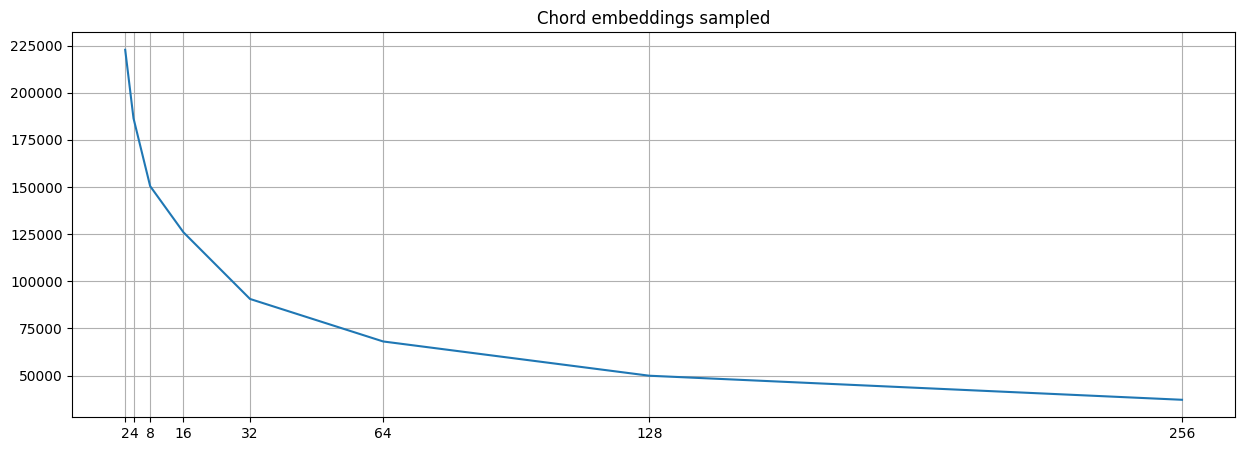

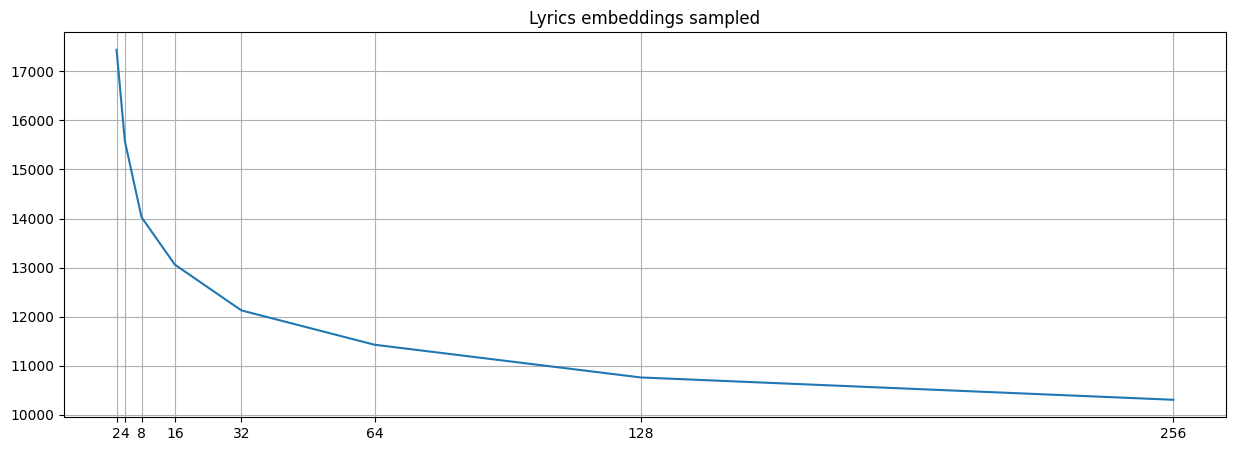

In [6]:
chords_kmeans = elbow(chords_embeddings_sampled.cpu().numpy(), [2**i for i in range(1,9)], label="Chord embeddings sampled")
lyrics_kmeans = elbow(lyrics_embeddings_sampled.cpu().numpy(), [2**i for i in range(1,9)], label="Lyrics embeddings sampled")

In [7]:
best_n_of_clusters = 16
chords_kmeans = chords_kmeans[16]
lyrics_kmeans = lyrics_kmeans[16]

chords_cluster_centers = torch.from_numpy(chords_kmeans.cluster_centers_).to(computing_device)
lyrics_cluster_centers = torch.from_numpy(lyrics_kmeans.cluster_centers_).to(computing_device)

In [8]:
# For each cluster get the nearest and farest to the cluster centers

chord_dist = torch.cdist(chords_cluster_centers, chords_embeddings_sampled)
chords_anchors = chord_dist.argmax(dim=1).tolist()
chords_anchors.extend(chord_dist.argmin(dim=1).tolist())
chords_anchors = list(set(chords_anchors))

lyrics_dist = torch.cdist(lyrics_cluster_centers, lyrics_embeddings_sampled)
lyrics_anchors = lyrics_dist.argmax(dim=1).tolist()
lyrics_anchors.extend(lyrics_dist.argmin(dim=1).tolist())
lyrics_anchors = list(set(lyrics_anchors))

anchors_from_dataset = list(set(lyrics_anchors + chords_anchors))

lyrics_anchors_embeddings = lyrics_embeddings_sampled.to(computing_device)[anchors_from_dataset]
chord_anchors_embeddings = chords_embeddings_sampled.to(computing_device)[anchors_from_dataset]

print(lyrics_anchors_embeddings.size(), chord_anchors_embeddings.size())

lyrics_relative_coordinates_anchors = torch.nn.functional.normalize(1 / (1 + torch.cdist(lyrics_embeddings_sampled, lyrics_anchors_embeddings)))
chords_relative_coordinates_anchors = torch.nn.functional.normalize(1 / (1 + torch.cdist(chords_embeddings_sampled, chord_anchors_embeddings)))

print(evaluate_asif(chords_relative_coordinates_anchors, lyrics_relative_coordinates_anchors, n_of_samples))
print(evaluate_asif(lyrics_relative_coordinates_anchors, chords_relative_coordinates_anchors, n_of_samples))

torch.Size([34, 768]) torch.Size([34, 256])
(25, 0.0025)
(11, 0.0011)


In [ ]:
# For each cluster get the nearest and farest to the cluster centers
n_of_random_anchors = 500
anchors_from_dataset = random.sample(range(0, n_of_samples-1), n_of_random_anchors)

lyrics_anchors_embeddings = lyrics_embeddings_sampled.to(computing_device)[anchors_from_dataset]
chord_anchors_embeddings = chords_embeddings_sampled.to(computing_device)[anchors_from_dataset]

lyrics_relative_coordinates_anchors = compute_relative_coordinates(lyrics_embeddings_sampled, lyrics_anchors_embeddings , k=2)
chords_relative_coordinates_anchors = compute_relative_coordinates(chords_embeddings_sampled, chord_anchors_embeddings, k=2)

print(lyrics_relative_coordinates_anchors.size())
print(chords_relative_coordinates_anchors.size())

print(evaluate_asif(chords_relative_coordinates_anchors, lyrics_relative_coordinates_anchors, n_of_random_anchors))
print(evaluate_asif(lyrics_relative_coordinates_anchors, chords_relative_coordinates_anchors, n_of_random_anchors))

torch.Size([10000, 500])
torch.Size([10000, 500])
(22, 0.044)
(41, 0.082)


In [43]:
dist.min(dim=1).indices

tensor([6712, 5357, 4582,  ...,  253, 9478, 4717], device='cuda:0')

In [37]:
lyrics_relative_coordinates_anchors

tensor([[0.1369, 0.1418, 0.1365,  ..., 0.1406, 0.1595, 0.1760],
        [0.1994, 0.1682, 0.1780,  ..., 0.1669, 0.1634, 0.1554],
        [0.1710, 0.1456, 0.1770,  ..., 0.1613, 0.1770, 0.1678],
        ...,
        [0.1794, 0.1666, 0.1760,  ..., 0.1641, 0.1535, 0.1562],
        [0.1746, 0.1737, 0.1727,  ..., 0.1882, 0.1610, 0.1593],
        [0.1396, 0.1401, 0.1423,  ..., 0.1409, 0.1562, 0.1721]],
       device='cuda:0')

In [21]:
lyrics_anchors_embeddings_rc = compute_relative_coordinates(lyrics_embeddings_sampled.to(torch.float32), lyrics_anchors_embeddings, k = len(lyrics_anchors_embeddings), p=1)
chords_anchors_embeddings_rc = compute_relative_coordinates(chords_embeddings_sampled.to(torch.float32), chord_anchors_embeddings, k = len(chords_embeddings_sampled), p=1)

chords_anchors_embeddings_rc.size(), lyrics_anchors_embeddings_rc.size()

(torch.Size([10000, 39]), torch.Size([10000, 39]))

In [26]:
lyrics_anchors_embeddings_rc[0].min()

tensor(0.1601)

In [22]:
correct_chords_to_lyrics =  evaluate_asif(chords_anchors_embeddings_rc, lyrics_anchors_embeddings_rc, n_of_samples=n_of_samples)
correct_lyrics_to_chords = evaluate_asif(lyrics_anchors_embeddings_rc, chords_anchors_embeddings_rc, n_of_samples=n_of_samples)
print(k, correct_chords_to_lyrics, correct_lyrics_to_chords)

9 10000 10000


In [ ]:

anchors_from_dataset_embeddings = torch.vstack([lyrics_anchors_embeddings_rc, chords_anchors_embeddings_rc])
anchors_from_dataset_embeddings.to(computing_device)

In [ ]:
# test chords to lyrics

ks = [p for p in range(1, 10)]
p = 1

kc = math.ceil(n_of_samples / best_n_of_clusters)

for k in ks:
    relative_coordinates_chord_clusters = compute_relative_coordinates(chords_cluster_centers, chords_embeddings_sampled, k=kc, p=p).to(computing_device)
    relative_coordinates_lyrics_clusters = compute_relative_coordinates(lyrics_cluster_centers, lyrics_embeddings_sampled, k=kc, p=p).to(computing_device)

    self_relative_coordinates_chords = compute_self_relative_coordinates(chords_embeddings_sampled, relative_coordinates_chord_clusters, batch_size=len(chords_embeddings_sampled), device=computing_device, k=k, p=p)
    self_relative_coordinates_lyrics = compute_self_relative_coordinates(lyrics_embeddings_sampled, relative_coordinates_lyrics_clusters, batch_size=len(lyrics_embeddings_sampled), device=computing_device, k=k, p=p)
    correct_chords_to_lyrics =  evaluate_asif(self_relative_coordinates_chords, self_relative_coordinates_lyrics, n_of_samples=n_of_samples)
    correct_lyrics_to_chords = evaluate_asif(self_relative_coordinates_lyrics, self_relative_coordinates_chords, n_of_samples=n_of_samples)
    print(k, correct_chords_to_lyrics, correct_lyrics_to_chords)

    anchors = torch.vstack([relative_coordinates_chord_clusters, relative_coordinates_lyrics_clusters])
    anchors = anchors.to(computing_device)
    self_relative_coordinates_chords_anchors = compute_self_relative_coordinates(chords_embeddings_sampled, anchors, batch_size=len(chords_embeddings_sampled), device=computing_device, k=k, p=p)
    self_relative_coordinates_lyrics_anchors = compute_self_relative_coordinates(lyrics_embeddings_sampled, anchors, batch_size=len(lyrics_embeddings_sampled), device=computing_device, k=k, p=p)
    correct_chords_to_lyrics =  evaluate_asif(self_relative_coordinates_chords_anchors, self_relative_coordinates_lyrics_anchors, n_of_samples=n_of_samples)
    correct_lyrics_to_chords = evaluate_asif(self_relative_coordinates_lyrics_anchors, self_relative_coordinates_chords_anchors, n_of_samples=n_of_samples)
    print(k, correct_chords_to_lyrics, correct_lyrics_to_chords)

1 853 853
1 2644 652
2 705 637
2 804 413
3 466 476
3 227 127
4 248 318
4 160 74
5 126 289
5 130 104
6 72 300
6 69 70
7 57 199
7 23 49
8 113 276
8 34 110
9 105 188
9 28 80
